## Imports

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from sqlalchemy import create_engine, MetaData, text
import json
from io import StringIO

---

## Carga de los dataset

In [40]:
# Optamos por cargar el primer dataset (datos metereológicos desde 1991 a 2020) desde un archivo excel que obtuvimos del sitio oficial
# del SMN: https://www.smn.gob.ar/descarga-de-datos. 
# # Saltamos las primeras 4 filas porque contienen información no relevante para el análisis.
df_91_20_wide = pd.read_excel("Estadísticas normales Datos abiertos 1991-2020.xlsx", skiprows=4)

#El segundo dataset corresponde a datos de temperatura de los últimos 365 días y lo cargamos desde un archivo de texto obtenido en el mismo sitio.
#Además salteamos las primeras 3 filas que contienen información no relevante y renombramos las columnas para que coincidan.

df_365 = pd.read_fwf("registro_temperatura365d_smn.txt", skiprows=3, names=["FECHA", "Temperatura Máx.", "Temperatura Mín.", "Estación"], encoding="latin1")


---

## Arreglo de los dataset

### Dataset 1991-2020

Encontramos dos problemas iniciales con este dataset: 
1. La forma en que se indican los datos faltantes es con la indicación "S/D", no reconocida por Pandas. 

2. La información se encuentra en un formato ancho ("wide format") donde no cumple con el formato "tidy" ideal para modelos de ML. 

In [41]:
# Primero solucionamos el problema de la referencia a los valores faltantes.
for col in df_91_20_wide.columns[2:]:
    df_91_20_wide[col] = (
        df_91_20_wide[col]
        .replace("S/D", pd.NA)          
    )

In [42]:
#Ahora solucionamos el segundo problema transformando el dataset en un formato long en el que cada variable tenga su propia columna 
# y cada observación su propia fila.

# Convertimos de formato wide a long con el método melt de pandas.
df_long= df_91_20_wide.melt(id_vars=['Estación', 'Valor Medio de'], var_name='Mes', value_name='Valor')
# Ahora pivoteamos para que las métricas sean columnas
df_91_20_tidy = df_long.pivot_table(index=['Estación', 'Mes'], columns='Valor Medio de', values='Valor').reset_index()

#Simplificamos algunos nombres de columnas.
df_91_20_tidy.rename(columns={
    'Humedad relativa (%)': 'Humedad relativa',
    'Nubosidad total (octavos)': 'Nubosidad total',
    'Precipitación (mm)': 'Precipitación',
    'Frecuencia de días con Precipitación superior a 1.0 mm': 'Prec. > a 1.0 mm',
    'Temperatura (°C)': 'Temperatura',
    'Temperatura máxima (°C)': 'Temperatura Máx.',
    'Temperatura mínima (°C)': 'Temperatura Mín.',
    'Velocidad del Viento (km/h) (2011-2020)': 'Viento'
}, inplace=True)

df_91_20_tidy.head()

Valor Medio de,Estación,Mes,Prec. > a 1.0 mm,Humedad relativa,Nubosidad total,Precipitación,Temperatura,Temperatura Máx.,Temperatura Mín.,Viento
0,AEROPARQUE AERO,Abr,6.6,73.6,3.5,108.3,18.5,22.0,15.3,13.9
1,AEROPARQUE AERO,Ago,5.0,73.6,3.9,61.5,12.9,16.5,9.7,14.0
2,AEROPARQUE AERO,Dic,6.6,65.1,3.2,112.8,23.2,27.4,19.2,15.9
3,AEROPARQUE AERO,Ene,6.7,67.0,3.1,117.5,24.5,28.4,20.8,16.8
4,AEROPARQUE AERO,Feb,6.0,69.8,3.2,112.3,23.7,27.3,20.2,15.8


Luego de esto podemos ver la diferencia entre cómo estaban arreglados los datos antes y cómo lo están ahora:

Arreglo inicial: 
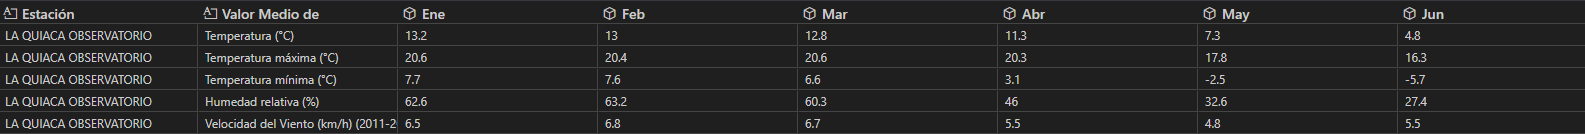

Arreglo tidy: 
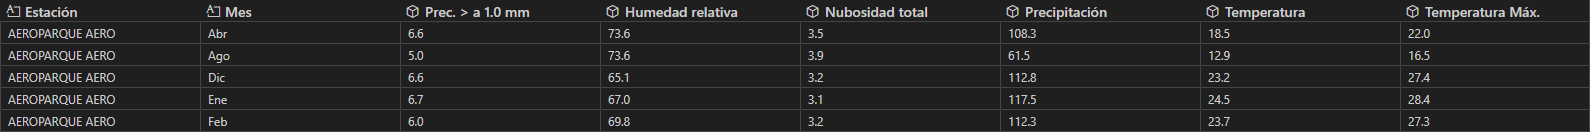

Puede notarse cómo ahora cada variable tiene su propia columna haciendo más fácil la selección de los Features y de la variable objetivo para el entrenamiento. Las primeras dos columnas actúan como una doble ID para las entradas, formadas por "Estación" + "Mes", de esta manera cada observación
corresponde a una estación determinada en un mes determinado. 

### Dataset de los últimos 365 días

Ahora debemos acomodar este segundo dataset para que sea compatible con el primero ya que vamos a hacer comparaciones entre ambos.

Observaciones: 

1. En los dos dataset figuran los datos de temperatura máxima y mínima que son los datos que vamos a comparar.


2. En el dataset de los últimos 365 días los datos están acomodados por día, a diferencia de las mediciones mensuales del primer dataset. Para solucionar esto elegimos agrupar las mediciones del segundo dataset en meses contando hasta el mes pasado (abril de 2025) ya que mayo no está completo.

3. También nos enfrentamos al problema de las estaciones en donde se realizaron las mediciones, en ambos dataset los nombres de algunas estaciones varían y también, como puede verse a continuación, la cantidad de estaciones es diferente.  

In [43]:
print("Cantidad de estaciones en dataset 91-20: ", df_91_20_tidy["Estación"].nunique())
print("Cantidad de estaciones en dataset 365: ", df_365["Estación"].nunique())

Cantidad de estaciones en dataset 91-20:  98
Cantidad de estaciones en dataset 365:  118


Por esta razón hemos decidido promediar las mediciones entre todas las estaciones para cada dataset a la hora de establecer las comparaciones entre ellos más adelante.

In [44]:
# Primero convertimos FECHA al formato datetime y agrupamos por meses.
df_365["FECHA"] = pd.to_datetime(df_365["FECHA"], format="%d%m%Y", errors='coerce')
df_365["Mes"] = df_365["FECHA"].dt.to_period("M")

# Eliminamos las filas correspondientes a mayo de 2025 y a enero, febrero, marzo y abril de 2024, para no tener mediciones de meses repetidas.
meses_a_excluir = ["2025-05", "2024-01", "2024-02", "2024-03", "2024-04"]
df_365 = df_365[~df_365["Mes"].isin(meses_a_excluir)]

#Eliminamos los datos faltantes. Siendo sólo el 1% de los datos, no es un problema para el análisis.
df_365 = df_365.dropna(axis=0)

#Ahora reemplazamos los valores de la columna "Mes" por los nombres de los meses para que coincida a cómo está en el otro dataframe.
meses = {
    '01': 'Ene',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Abr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Ago',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dic'
}

df_365['Mes'] = df_365['FECHA'].dt.strftime('%m').map(meses)

# Calculamos el promedio mensual de las temperaturas máximas y mínimas entre todas las estaciones juntas
df_365_tidy = df_365.groupby("Mes")[["Temperatura Máx.", "Temperatura Mín."]].mean().round(1)

df_365_tidy.head()

,Temperatura Máx.,Temperatura Mín.
Mes,,
Abr,20.5,9.3
Ago,15.7,3.7
Dic,27.1,13.7
Ene,29.4,15.8
Feb,29.1,16.3


Finalmente quedamos con los dos dataset en un formato compatible para la comparación de las temperaturas máximas y mínimas promediadas mensualmente.

El EDA que realizaremos a continuación, de todas maneras, estará centrado en el dataset 91-20 ya que es mucho más rico en información que el otro, al que sólo usaremos para dicha comparación. 



In [ ]:
#Para finalizar renombramos ambos datasets para trabajar con ellos y reordenamos las columnas de df_91_20. 
df_91_20 = df_91_20_tidy

nuevo_orden = ['Estación',                   #Variables de id      
               'Mes',                               
               'Precipitación',              #Variables climáticas
               'Prec. > a 1.0 mm', 
               'Humedad relativa', 
               'Nubosidad total', 
               'Viento',              
               'Temperatura',                #Variables de temperatura
               'Temperatura Máx.',
               'Temperatura Mín.',
]

df_91_20 = df_91_20_tidy[nuevo_orden]

*Nota: entendemos que las mediciones de temperatura también son consideradas parte del clima, pero elegimos esta clasificación para diferenciar aquellas variables estrictamente ligadas a la temperatura de las demás.*

---

## EDA

#### Descripción del dataset 91-20
Todas las variables son de tipo **numéricas continuas** salvo las dos primeras columnas que son **categóricas**.

| Columna            | Descripción                                                                         |
| -------------      | ------------------------------------------------------------------------------------|
| `Estación`         | El nombre de la estación desde donde se tomaron los datos.                          |
| `Mes`              | El mes al que corresponden las mediciones.                                          |
| Mediciones         | ------------------------------------------------------------------------------------|
| `Precipitación`    | La precipitación, en milímetros.                                                    | 
| `Prec. > a 1.0 mm` | Cantidad de días que llovió más de 1 milímetro.                                     |
| `Humedad relativa` | La humedad relativa.                                                                | 
| `Nubosidad total`  | La nubosidad, expresada en octavos.                                                 | 
| `Viento`           | La velocidad del viento, en km/h.                                                   | 
| `Temperatura`      | La temperatura promedio, en °C.                                                     | 
| `Temperatura Máx.` | La temperatura máxima, en °C.                                                       | 
| `Temperatura Mín.` | La temperatura mínima, en °C.                                                       | 

**Ahora vemos la cantidad de entradas del dataset junto con una muestra del mismo.**


In [46]:
# Ahora vemos la cantidad de entradas del dataset.
print("Cantidad de muestras: ", df_91_20.shape[0])
print("Muestra: ")
df_91_20.head(10)


Cantidad de muestras:  1171
Muestra: 


Valor Medio de,Estación,Mes,Precipitación,Prec. > a 1.0 mm,Humedad relativa,Nubosidad total,Viento,Temperatura,Temperatura Máx.,Temperatura Mín.
0,AEROPARQUE AERO,Abr,108.3,6.6,73.6,3.5,13.9,18.5,22.0,15.3
1,AEROPARQUE AERO,Ago,61.5,5.0,73.6,3.9,14.0,12.9,16.5,9.7
2,AEROPARQUE AERO,Dic,112.8,6.6,65.1,3.2,15.9,23.2,27.4,19.2
3,AEROPARQUE AERO,Ene,117.5,6.7,67.0,3.1,16.8,24.5,28.4,20.8
4,AEROPARQUE AERO,Feb,112.3,6.0,69.8,3.2,15.8,23.7,27.3,20.2
5,AEROPARQUE AERO,Jul,64.3,5.0,75.5,4.1,13.2,11.3,14.4,8.4
6,AEROPARQUE AERO,Jun,54.6,4.5,76.3,4.2,12.2,12.3,15.5,9.4
7,AEROPARQUE AERO,Mar,111.8,5.9,71.3,3.1,14.9,22.0,25.5,18.8
8,AEROPARQUE AERO,May,83.3,5.0,76.4,4.0,12.9,15.2,18.4,12.3
9,AEROPARQUE AERO,Nov,103.2,6.8,67.0,3.5,17.1,20.6,24.5,16.8


**Ajustamos los tipos de datos de las columnas numéricas que en este momento siguen siendo de tipo *object***.

In [47]:
df_91_20['Precipitación'] = df_91_20['Precipitación'].astype('float64')
df_91_20['Prec. > a 1.0 mm'] = df_91_20['Prec. > a 1.0 mm'].astype('float64')
df_91_20['Humedad relativa'] = df_91_20['Humedad relativa'].astype('float64')
df_91_20['Nubosidad total'] = df_91_20['Nubosidad total'].astype('float64')
df_91_20['Viento'] = df_91_20['Viento'].astype('float64')
df_91_20['Temperatura'] = df_91_20['Temperatura'].astype('float64')
df_91_20['Temperatura Máx.'] = df_91_20['Temperatura Máx.'].astype('float64')
df_91_20['Temperatura Mín.'] = df_91_20['Temperatura Mín.'].astype('float64')

df_91_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Estación          1171 non-null   object 
 1   Mes               1171 non-null   object 
 2   Precipitación     1061 non-null   float64
 3   Prec. > a 1.0 mm  1061 non-null   float64
 4   Humedad relativa  1110 non-null   float64
 5   Nubosidad total   1166 non-null   float64
 6   Viento            708 non-null    float64
 7   Temperatura       1167 non-null   float64
 8   Temperatura Máx.  1158 non-null   float64
 9   Temperatura Mín.  1124 non-null   float64
dtypes: float64(8), object(2)
memory usage: 91.6+ KB


---

## Exploración de las variables categóricas

**Variable 'Estaciones':** 

Como ya hemos dicho antes esta variable tiene 98 valores únicos cada uno correspondiente a una estación desde donde se registraron los datos del dataset. Para nosotros esta variable no reviste mucho interés porque no se puede extraer demasiado significado de ella, sería interesante por ejemplo, que las estaciones estuvieran agrupadas por provincia o región del país para poder sacar conclusiones más significativas pero lamentablemente no es el caso. 

**Variable 'Meses':**

Esta variable es simplemente una variable categórica que representa los meses del año y se puede utilizar para hacer análisis interesantes y sacar conclusiones sobre cómo varían las diferentes facetas del clima en función de ellos y de las estaciones del año.

Dado que ambas variables funcionan como Id no tienen valores faltantes.

In [54]:
print(df_91_20["Estación"].isna().sum())
print(df_91_20["Mes"].isna().sum())

0
0


---

## Exploración de las variables numéricas

Primero realizamos una descripción general de las mismas.



In [48]:
df_91_20.describe()

Valor Medio de,Precipitación,Prec. > a 1.0 mm,Humedad relativa,Nubosidad total,Viento,Temperatura,Temperatura Máx.,Temperatura Mín.
count,1061.000000,1061.000000,1110.000000,1166.000000,708.000000,1167.000000,1158.000000,1124.000000
mean,68.234873,5.097455,68.005405,3.840137,13.011582,14.834190,21.223834,9.102847
std,51.674519,2.536586,11.027475,0.888284,5.554040,8.178787,8.938676,7.778743
min,0.000000,0.000000,25.700000,1.300000,3.900000,-20.900000,-17.500000,-25.000000
25%,23.300000,3.100000,61.325000,3.300000,9.200000,10.300000,17.025000,4.500000
50%,58.900000,5.200000,70.100000,3.700000,11.800000,15.700000,22.400000,9.900000
75%,106.500000,7.000000,76.400000,4.200000,15.900000,21.200000,27.900000,15.100000
max,277.900000,13.800000,90.200000,7.500000,36.500000,28.300000,35.500000,22.500000



A simple vista se puede ver que la variable **viento** tiene una gran cantidad de valores nulos.

In [61]:

print("Porcentaje de datos faltantes en la columna viento: ", (df_91_20["Viento"].isna().sum()*100/df_91_20.shape[0]).__round__(2), "%")

Porcentaje de datos faltantes en la columna viento:  39.54 %


El porcentaje de entradas que no tienen un valor de viento es del 39%.Tenemos la sospecha de que esto pueda deberse a que haya estaciones donde directamente no se haya realizado esa medición, y no porque las mediciones hayan sido erráticas, verifiquemos:

In [76]:
# Filtramos las estaciones que tienen datos de viento.
estaciones_con_viento = df_91_20[df_91_20["Viento"].notnull()]["Estación"].unique()

# Contamos el porcentaje de estaciones que tienen datos de viento.
porcentaje_estaciones_con_viento = (len(estaciones_con_viento) / df_91_20["Estación"].nunique()) * 100

print("Porcentaje de estaciones que no midieron el viento:", 100 - porcentaje_estaciones_con_viento.__round__(2), "%")

Porcentaje de estaciones que no midieron el viento: 39.8 %


Dado que el porcentaje de estaciones que no midieron el viento coincide casi a la perfección con el porcentaje de datos faltantes en esa columna podemos aventurarnos a asegurar que la falta de esos datos se debe a esa razón. Elegimos representar esto con una flag que indique si el viento fue medido o no. 

Lamentablemente la cantidad de faltantes es muy elevada como para realizar una imputación.

In [77]:
df_91_20["Viento_medido"] = df_91_20["Viento"].notnull()

Otras variables que llamaron nuestra atención son **precipitación** y **prec. > a 1.0 mm**, ambas tienen también una cantidad considerable de datos faltantes:

In [87]:
print("Porcentaje de datos faltantes en la columna precipitación: ", (df_91_20["Precipitación"].isna().sum()*100/df_91_20.shape[0]).__round__(2), "%")

Porcentaje de datos faltantes en la columna precipitación:  9.39 %


Dado que ambas columnas tienen la misma cantidad de datos, ese 9.39% de datos faltantes pertenece a ambas. Resolvimos imputar estas variables... Trabajando acá.

---

### Exploración de las variables climáticas (no temperatura)

Lo siguiente más bien podría ser para contestar alguna pregutnta sobre le distribución de las lluvias en cada mes en vez de ser parte del EDA.

**Promedios mensuales:**

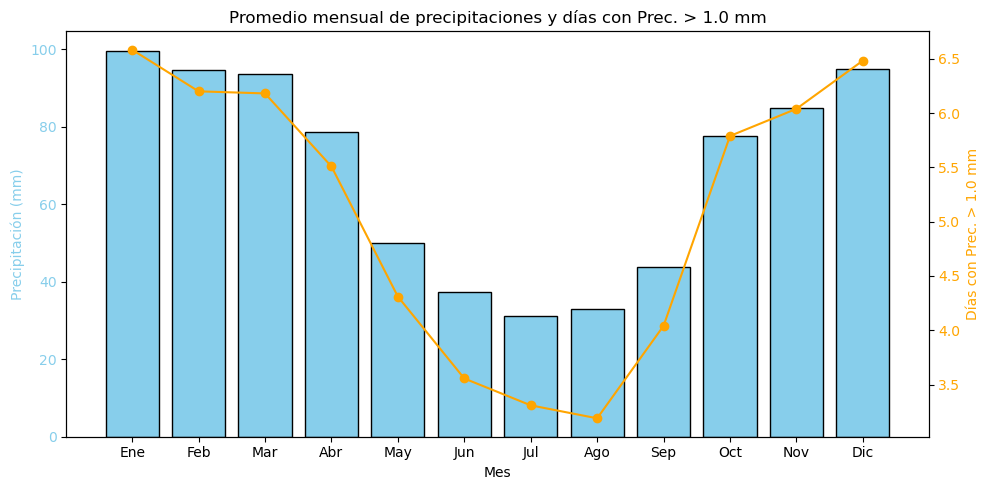

In [89]:
# Queremos ver un gráfico que represente el promedio de precipitaciones por mes entre 1991 y 2020 
# junto con la cantidad de días con mediciones mayores a 1mm.

# Para eso primero sacamos el promedio para cada mes. 
df_prom_mensual_precipitacion = df_91_20.groupby('Mes')['Precipitación'].mean()
df_prom_mensual_prec_gt_1mm = df_91_20.groupby('Mes')["Prec. > a 1.0 mm"].mean()

# Reodrenamos los dataset
meses_orden = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
df_prom_mensual_ordenado = df_prom_mensual_precipitacion.reindex(meses_orden)
df_prec_gt1_ordenado = df_prom_mensual_prec_gt_1mm.reindex(meses_orden)


# Gráficamos
fig, ax1 = plt.subplots(figsize=(10, 5))

# Barras: Precipitación
ax1.bar(df_prom_mensual_ordenado.index, df_prom_mensual_ordenado.values, color='skyblue', edgecolor='black', label='Precipitación (mm)')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Precipitación (mm)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Línea de Prec. > 1.0 mm
ax2 = ax1.twinx()
ax2.plot(df_prec_gt1_ordenado.index, df_prec_gt1_ordenado.values, color='orange', marker='o', label='Prec. > 1.0 mm')
ax2.set_ylabel('Días con Prec. > 1.0 mm', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Promedio mensual de precipitaciones y días con Prec. > 1.0 mm')
fig.tight_layout()
plt.show()

In [ ]:
intensidad_media = precipitación_total / días_con_prec_gt_1mm